In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Demand-supply equilibration on roads
## Saves car LoS table with travel time after equilibrium assignment
## Needs road_links with assigned volumes

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [7]:
# Load road network and assignment results
sm = stepmodel.read_json(model_path + 'de_road_access_egress')
a = stepmodel.read_zippedpickles(model_path + 'de_assignment')
sm.road_links = a.road_links
sm.volumes = a.volumes
a.links = None
a.loaded_links = None

In [8]:
# pkm on roads from inter-zonal traffic
(sm.road_links["('all', 'car')"] * sm.road_links['length'] /1000).sum() / 1e9

985.2937496885997

## Road capacity

If not computed before, calculate the road link capacity as a function of maximum speed and the number of lanes by the type of road. Sources:
* https://www.fhwa.dot.gov/policyinformation/pubs/pl18003/hpms_cap.pdf
* https://edocs.tib.eu/files/e01fn12/689343728.pdf

In [9]:
# The road load from goods transport is relevant
freight_share_motorway = 0.1
freight_share_other = 0.03

In [10]:
# Function to calculate capacity in vehicles/h
def capacity(maxspeed, n_lanes, road_type):
    if road_type == 'motorway':
        return (2200 + 10 * (min(70, maxspeed/1.61) - 50)) \
                / (1+freight_share_motorway) * n_lanes
    elif road_type == 'primary':
        return min(2200, 1000 + 20 * maxspeed/1.61) \
                / (1+freight_share_other) * n_lanes
    else:
        return 1500

In [11]:
assert sm.road_links['lanes'].isna().max() == 0
assert sm.road_links['maxspeed'].isna().max() == 0
assert sm.road_links['highway'].isna().max() == 0
if not 'capacity' in sm.road_links.columns:
    sm.road_links['capacity'] = [capacity(v, n, t) for v,n,t in zip(
        sm.road_links['maxspeed'], sm.road_links['lanes'], sm.road_links['highway'])]
    # Scale capacity from vehicles/h to vehicles/year
    sm.road_links['capacity'] *= 24 * 365
    # Multiply by 2 in order to account for both directions
    sm.road_links['capacity'] *= 2

In [13]:
# Define capacity of Sylt car train
# max 110 cars in 1.5 hours between 4:30 a.m. and 7:30 p.m.
sm.road_links.loc['sylt_train', 'capacity'] = 110 / 1.5 * 15 * 365

In [40]:
# Calibration
sm.road_links['capacity'] *= 6

## Road level-of-service

Compute level-of-service categories for road links and compare them to observed values for Germany in: "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020, p. 51.

LoS categories correspond to the ratio of flow to capacity:
* A: Q/C <= 0.35
* B: 0.35 < Q/C <= 0.55
* C: 0.55 < Q/C <= 0.75
* D: 0.75 < Q/C <= 0.9
* E: 0.9 < Q/C <= 1
* F: Q/C > 1

In [14]:
sm.road_links['los'] = pd.cut(sm.road_links["('all', 'car')"] / sm.road_links['capacity'],
                              bins=[-1, 0.35, 0.55, 0.75, 0.9, 1, np.inf],
                              labels=list('ABCDEF'))

In [15]:
# Share of freeway km with specific service levels
mask = sm.road_links['highway']=='motorway'
sm.road_links.loc[mask].groupby('los')['length'].sum() \
    / sm.road_links.loc[mask, 'length'].sum()

los
A    0.993880
B    0.005598
C    0.000508
D    0.000013
E    0.000000
F    0.000000
Name: length, dtype: float64

In [16]:
# Share of primary road km with specific service levels
mask = sm.road_links['highway']=='primary'
sm.road_links.loc[mask].groupby('los')['length'].sum() \
    / sm.road_links.loc[mask, 'length'].sum()

los
A    9.996138e-01
B    3.123374e-04
C    6.003795e-05
D    2.439628e-06
E    4.330701e-08
F    1.129591e-05
Name: length, dtype: float64

## Define parameters for travel time function

The default function comes from :

$t=t_0 * \left( 1 + \alpha*\frac{V}{C}^{\beta} \right)$

With free-flow travel time $t_0$, link volume $V$, link capacity $C$, and parameters $\alpha,\beta$.

In [17]:
sm.road_links['alpha'] = 0.15
sm.road_links['beta'] = 4
#sm.road_links['limit'] = applied in limited_bpr function, not relevant
sm.road_links['penalty'] = 0 # adds up on the respective link

## Find best paths

Use the Frank-Wolffe algorithm for constrained equilibrium assignment

In [18]:
vol_col = 'volume_car'
if not vol_col in sm.volumes.columns:
    sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
    sm.volumes[vol_col] = sm.volumes[sm.segments].sum(axis=1) * 0.89

In [19]:
# Mio. trips by car
sm.volumes['volume_car'].sum() / 1e6

16068.513926687858

In [20]:
if not 'time' in sm.road_links.columns:
    # See prep30
    
    # For up to 60km/h average speed equals the speed limit
    mask60 = sm.road_links['maxspeed']<=60
    sm.road_links.loc[mask60, 'time'] = sm.road_links['length'] / 1000 \
        / sm.road_links['maxspeed'] * 3600

    # Then, up to under 100km/h, average speeds are 10% above the speed limit
    mask100 = sm.road_links['maxspeed']<100
    sm.road_links.loc[(~mask60)&(mask100), 'time'] = \
        sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600 * 1.1

    # Then, speed follows a polynomial of y = -0,0115x2 + 3,145x - 96,2 (R^2=1)
    mask_not_open = sm.road_links['maxspeed']!=125
    sm.road_links.loc[(~mask100)&(mask_not_open), 'time'] = sm.road_links['length'] / 1000 / \
        (-0.0115*np.power(sm.road_links['maxspeed'], 2)
         + 3.145*sm.road_links['maxspeed'] - 96.2) * 3600

    # without speed limit
    sm.road_links.loc[~mask_not_open, 'time'] = sm.road_links['length'] / 1000 \
        / sm.road_links['maxspeed'] * 3600

    assert len(sm.road_links[sm.road_links['time'].isna()])==0
    sm.road_links.loc[sm.road_links['time']==0, 'time'] = 1

In [41]:
sm.step_road_pathfinder(method='bfw',
                        maxiters=100,
                        num_cores=30,
                        tolerance=0.5, # in %
                        log=True)

iteration | Phi |  Rel Gap (%)
0 0.1531 23.847
1 0.1359 10.883
2 0.1187 4.929
3 0.1094 2.341
4 0.1734 1.271
5 0.1313 0.684
6 0.3859 0.477


In [42]:
print('Total time on road_links: {}'.format(
    ((sm.road_links['time'] * sm.road_links["('all', 'car')"]).sum() / 3600 / 1e6).round(0)))
print('Total time with congestion: {}'.format(
    ((sm.road_links['jam_time'] * sm.road_links['flow']).sum() / 3600 / 1e6).round(0)))

Total time on road_links: 10469.0
Total time with congestion: 70990.0


In [45]:
# Calculate LoS again
sm.road_links['los_eq'] = pd.cut(sm.road_links['flow'] / sm.road_links['capacity'],
                                 bins=[-1, 0.35, 0.55, 0.75, 0.9, 1, np.inf],
                                 labels=list('ABCDEF'))

In [46]:
# Share of freeway km with specific service levels
mask = sm.road_links['highway']=='motorway'
sm.road_links.loc[mask].groupby('los_eq')['length'].sum() \
    / sm.road_links.loc[mask, 'length'].sum()

los_eq
A    0.657403
B    0.160333
C    0.104374
D    0.039234
E    0.013210
F    0.025446
Name: length, dtype: float64

In [47]:
# Share of primary road km with specific service levels
mask = sm.road_links['highway']=='primary'
sm.road_links.loc[mask].groupby('los_eq')['length'].sum() \
    / sm.road_links.loc[mask, 'length'].sum()

los_eq
A    0.999520
B    0.000381
C    0.000055
D    0.000025
E    0.000015
F    0.000003
Name: length, dtype: float64

In [48]:
# pkm on roads from inter-zonal traffic after equilibration
(sm.road_links["flow"] * sm.road_links['length'] /1000).sum() / 1e9

7097.302215146662

<AxesSubplot:>

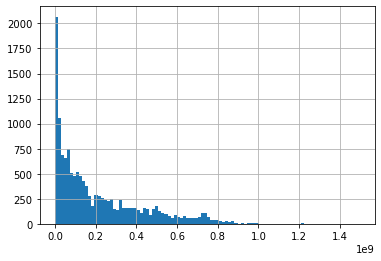

In [54]:
sm.road_links.loc[sm.road_links['highway']=='motorway','flow'].hist(bins=100, log=False)

<AxesSubplot:>

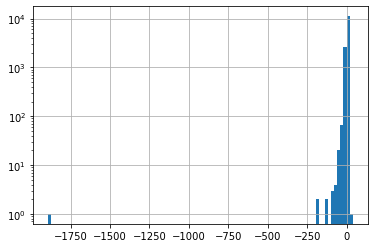

In [56]:
mask = sm.road_links['highway']=='motorway'
(sm.road_links.loc[mask, 'time'] - sm.road_links.loc[mask, 'jam_time']).hist(bins=100, log=True)

In [131]:
sm.road_links.loc[((sm.road_links['time'] - sm.road_links['jam_time'])<-100) & (mask),
                  ['ref', 'length', 'maxspeed', 'lanes']]

,ref,length,maxspeed,lanes
index,,,,
rl_64432,A 9,4464,125.0,2
rl_64433,A 9,4462,125.0,1
rl_132830,A 7,183,100.0,3
rl_133054,A 7,9372,125.0,4
rl_133075,A 7,9679,125.0,4


### Visualise

In [123]:
from syspy.syspy_utils.data_visualization import bandwidth
import geopandas as gpd
z = stepmodel.read_json(model_path + 'de_zones')
sm.zones = gpd.GeoDataFrame(z.zones)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.road_links['flow_s'] = sm.road_links['flow'] / 1e6

<AxesSubplot:>

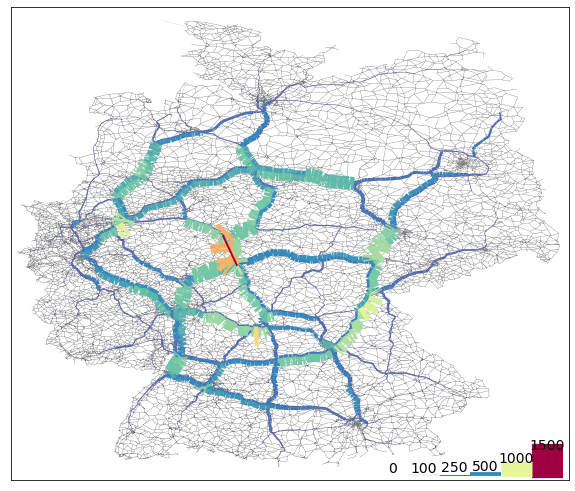

In [127]:
bandwidth(sm.road_links.loc[mask], value_column='flow_s',
          power=2, legend_values=[0, 100, 250, 500, 1000, 1500],
          geographical_bounds=(5.866250350607375, 47.27012360603612, 15.041815652514362, 55.05877771705553),
          #geographical_bounds=sm.zones['geometry'].unary_union.envelope.bounds,
          line_offset=True, variable_width=True, max_linewidth_meters=.5,
          figsize=(10,10), label_kwargs={'color':'black', 'fontsize':14})

## Save

Save results under a different path: scenario + 'equilibrium'

In [ ]:
# Drop unneccesary columns
sm.road_links.drop([c for c in sm.road_links.columns if c.startswith('[')],
                   axis=1, inplace=True, errors='ignore')

In [ ]:
if not os.path.exists(model_path + '_equilibrium/'):
    os.makedirs(model_path + '_equilibrium/')
    sm.to_json(model_path + '_equilibrium/' + 'de_road_network',
               only_attributes=['road_links'], encoding='utf-8')
elif scenario.endswith('equilibrium'):
    sm.to_json(model_path + 'de_road_network',
               only_attributes=['road_links'], encoding='utf-8')
else:
    sm.to_json(model_path + '_equilibrium/' + 'de_road_network',
               only_attributes=['road_links'], encoding='utf-8')